# The Pipeline

## Gather Your Tools

* linux distro 
* python 3.6<
* tensorflow-gpu<2
* pytourch
* NLTK
* Pandas
* conda/bioconda
* matplotlib
* jupyter notebook
* eutils/toolkit
* lamp (or whatever I end up calling it)
* cuda 10.1

# Import Thesis Data
The data files are included in the lamp pip install and can be accessed via the load_thesis_data command.




In [1]:
from lamp.load_thesis_data import load_thesis_data
data = load_thesis_data()

Dictionary of Thesis Data as Absolute File Locations



Data Dictionary Includes:

| Key                          | Value                       |
|------------------------------|--------------------         |
|   bacteria_lamp_pretrained   | Our Trained ANN             |
|bacteria_lamp_labeled_data    | labeld data for ANN training|
|   add_drop                   | table of drop words         |
|   species_list               | list of posible gut bacteria|


# Simple Usage
Here you can go ahead and play around with the n variable below to pick randomly from the sentence pool

In [3]:
n = 40 # pick a sentence to run
# import dependancies
import pandas as pd
from transformers import pipeline
from lamp.sentence import clean
from transformers import pipeline

## Example Sentence From Labeled Data

In [3]:
#choose a sentence
df = pd.read_csv(data['bacteria_lamp_labeled_data'], sep = '\t')
sentence = df.text.iloc[n]
label = df.label.iloc[n]
# print what is logged
print(sentence +'\n')
print('Labeled as %s'%['POSITIVE' if label== 0 else 'NEGATIVE'][0])

Actinomyces graevenitzii was shown to be significantly associated with  the halitosis condition.

Labeled as NEGATIVE


In [4]:
# clean/lemmitize the sentence and run it through our pretrained ANN
classifier = pipeline('sentiment-analysis',model=data['bacteria_lamp_pretrained'])
print('Prediction By Our ANN:')
classifier((clean(sentence, add_drop = data['add_drop'])))

Prediction By Our ANN:


[{'label': 'NEGATIVE', 'score': 0.9947972893714905}]

# Data Mining
Abstracts are the most information rich part of text. Here we will mine for abstracts pretaining to organisms of interest. This part of the project was done first in order to get enough sentences to tag to feed through the ANN. Here we are simply mining from NCBI PubMed, but we could expand the search in the future.

Lets use Bacteroides clarus as an example species

## <font color='red'>Data Mining Down For Now</font>

Eutils is currently down 10/21/2020. Hopefully it is back up when you get to this code.

# Tokenize sentences
Now that we have abstracts we need to tokenize them to sentences. We could tag entire abstracts, but that is too reductive for our purposes. Luckily NLTK has a tokenizer that we will utilize that does a much better job than looking for punctuation and capitalization.

# Only take Sentences With Mention of Species
The next step is to only take the sentences pretaining to our bacteria of interest. Many sentences have implied subjects and that is not going to help us much here, so we are being more explicit in our approach.

# Lather Rinse Repeat
Now that we have our means of mining, tokenizing to sentence, and selecting our sentences of interest we can do this on a large scale. We will mine all of the species from our species list and add the sentences found to a file. Once this file is complete we will move on to tagging.

Note: No need to mine you can just use the bacteria_lamp.tsv provided that has all of the sentences and the tags, but if you wish to expand the list this is a way of doing it.

You should set up an api key to do this at https://ncbi.gov

# Tagging
Now it is time to tag the data where 1=Positive and 0=Negative. Here I set up a Python Django webapp on Microsoft Azure so that I could call on the Holobiome team of microbiologists to tag the data using their expert opinions. This way the data can be edited and shared via a relational database (in this case Postgresql).

See the webapp here: https://datahound20200729.azurewebsites.net/

# Word Stats
Basic statistics of word usage can help us better prepare for the training of our NLP. Let us take a look at the raw sentences as well as some lemmitized and clean sentences.

Note I am going to use the bacteria_lamp.tsv file for this next phase, not the sentences.tsv file that was produced above. The reason for this is because the bacteria_lamp.tsv file also contains the tags that my team has created. Some of which include tags to drop bad sentences.

In [4]:
%matplotlib notebook
df = pd.read_csv(data['bacteria_lamp_labeled_data'],sep = '\t')
# df = df.loc[(df.label == 1)|(df.label == 0)]
sentences = list(df.text.values)

<IPython.core.display.Javascript object>


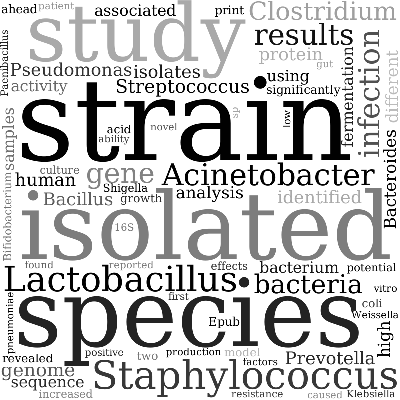

<module 'matplotlib.pyplot' from '/home/boom/anaconda3/envs/qiime2/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [5]:
from lamp.sentence import word_cloud, word_stats
word_cloud(word_stats(sentences), font_path = 'boom')

## Drop Words and Lemmitize
As we can see from the graphic above we must remove the genus and species names and also we would like to remove words such as "the" and "is" etc. as they are getting in the way of analyzing the other content within the sentence.

We will also lemmitize as this is a normal part of the process. Words often have congugates such as wanted and wanting, but the root of the word is where the meat is (want).

<IPython.core.display.Javascript object>


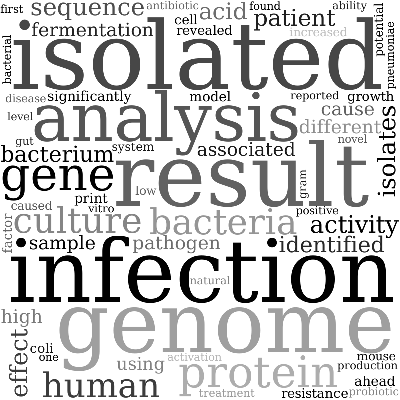

<module 'matplotlib.pyplot' from '/home/boom/anaconda3/envs/qiime2/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [21]:
clean_sentences = [clean(sentence,add_drop=data['add_drop']) for sentence in sentences]
ws = word_stats(clean_sentences)
word_cloud(ws, font_path = 'boom')

## Clean is Good
As we can see the cleaning process made some of the words we care about most more promanent. In the future we can always append the stopwords list or you can make your own to use in this pipeline.

# Artificial Neural Networks

## Pretrained ANN Accuracy

In [8]:
from lamp.train import train, evaluate
ev = evaluate(data['bacteria_lamp_labeled_data'],'distilbert-base-uncased-finetuned-sst-2-english')
print('Pretrained\nAccuracy is at %f'%ev['accuracy'])

Pretrained
Accuracy is at 55.405405


## Train on top of existing ANN

In [ ]:
# train(trainset=data['bacteria_lamp_labeled_data']
#                train_size = 0.80,
#                test_size = 0.10,
#                valid_size = 0.10))

## Evaluate bacteria_lamp_pretrained

In [22]:
ev = evaluate(data['bacteria_lamp_labeled_data'],data['bacteria_lamp_pretrained'])
print('LAMP Model\nAccuracy is at %f'%ev['accuracy'])

LAMP Model
Accuracy is at 90.090090


## Conclusion
accuracy of distilbert-base-uncased-finetuned-sst-2-english:
* 55.405405 %

accuracy of bacteria_lamp_pretrained:
* 90.090090 %

In [28]:
out = open('misslabeled.txt','w')
[out.write(i+'\n\n') for i in list(ev['misslabeled'].text.values)]
out.close()